In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import os
from glob import glob

## Bias Test Results Loading Functions

In [2]:
def get_gen_properties(filename):
  props = {'shot_strategy':'', "gen_model":'', 'temperature':'', 'gen_id':''}
      
  #get shot strategy
  for s in ['fixed', 'similarity', 'dynamic']:
    if s in filename:
      if s in ['similarity','dynamic']:
        props['shot_strategy'] = 'similarity'
      else:
        props['shot_strategy'] = s
  
  #gen model
  for m in ['gpt-3.5', 'gpt-j-6b', 'neo-125m', 'neo-2.7b', 'nvidia', 'baseline', 'filtered']:
    if m in filename.lower():
      props['gen_model'] = m
      if 'nvidia' in filename.lower():
        props['gen_model'] = 'meg-530b'
        props['shot_strategy'] = 'similarity'

  #get temperature
  for t in ['temp-0.5', 'temp-0.8']:
    if t in filename:
      props['temperature'] = float(t[5:])

  #get generation id
  for gid in ['-1_pairs.csv', '-2_pairs.csv', '-3_pairs.csv', '-4_pairs.csv', '-5_pairs.csv']:
    if filename.endswith(gid):
      props['gen_id'] = int(gid[1:2])

  return props

def loadBiasTests(bias_test_path, require_gen_model=True, gen_label="template"):
  source_dir = os.path.join(bias_test_path)

  n = 0
  raw_repeat_gens_df = pd.DataFrame()

  for test_model_dir in os.listdir(source_dir):
    print("Test model DIR:", test_model_dir)
    
    # For Generator PLM sentences
    if require_gen_model == True:
      for gen_model_dir in os.listdir(os.path.join(source_dir, test_model_dir)):
        print("Gen model DIR:", gen_model_dir)
        gen_files = glob(os.path.join(source_dir, test_model_dir, gen_model_dir, "*.csv"))
        print(f"Gen files: {len(gen_files)}")
        for gen_file in gen_files:
          print("File:", gen_file)

          bias_test_df = pd.read_csv(gen_file, index_col=0)

          props = get_gen_properties(os.path.basename(gen_file))

          # individual generations
          bias_test_df['gen_model'] = props['gen_model']
          bias_test_df['test_model'] = str(test_model_dir)
          bias_test_df['temperature'] = props['temperature']
          bias_test_df['shot_strategy'] = props['shot_strategy']
          bias_test_df['gen_id'] = props['gen_id']

          raw_repeat_gens_df = pd.concat([raw_repeat_gens_df, bias_test_df], ignore_index=True)
    # For manual templates (no generator)
    else:
      print("No generator - templates!!!")
      gen_files = glob(os.path.join(source_dir, test_model_dir, "*.csv"))
      print(f"Gen files: {len(gen_files)}")
      for gen_file in gen_files:
        print("File:", gen_file)

        bias_test_df = pd.read_csv(gen_file, index_col=0)

        props = get_gen_properties(os.path.basename(gen_file))

        # individual generations
        bias_test_df['gen_model'] = gen_label
        bias_test_df['test_model'] = str(test_model_dir)
        bias_test_df['temperature'] = props['temperature']
        bias_test_df['shot_strategy'] = props['shot_strategy']
        bias_test_df['gen_id'] = props['gen_id']

        raw_repeat_gens_df = pd.concat([raw_repeat_gens_df, bias_test_df], ignore_index=True)
  
  return raw_repeat_gens_df

## Load Results for Core Biases

In [4]:
raw_repeat_gens_df = loadBiasTests("./dataset_core_biases/gen_ss_test")
display(raw_repeat_gens_df.groupby(['gen_model','test_model'])['group'].agg(['count']))

print(f"Biases: {raw_repeat_gens_df['group'].unique()}")

Test model DIR: biogpt
Gen model DIR: nvidia-megatron-530b
Gen files: 5
File: ./dataset_core_biases/gen_ss_test/biogpt/nvidia-megatron-530b/nvidia-temp-0.8-shots-5-1_pairs.csv
File: ./dataset_core_biases/gen_ss_test/biogpt/nvidia-megatron-530b/nvidia-temp-0.8-shots-5-2_pairs.csv
File: ./dataset_core_biases/gen_ss_test/biogpt/nvidia-megatron-530b/nvidia-temp-0.8-shots-5-4_pairs.csv
File: ./dataset_core_biases/gen_ss_test/biogpt/nvidia-megatron-530b/nvidia-temp-0.8-shots-5-3_pairs.csv
File: ./dataset_core_biases/gen_ss_test/biogpt/nvidia-megatron-530b/nvidia-temp-0.8-shots-5-5_pairs.csv
Gen model DIR: gpt-3.5
Gen files: 5
File: ./dataset_core_biases/gen_ss_test/biogpt/gpt-3.5/similarity-gpt-3.5-temp-0.8-shots-5-2_pairs.csv
File: ./dataset_core_biases/gen_ss_test/biogpt/gpt-3.5/similarity-gpt-3.5-temp-0.8-shots-5-4_pairs.csv
File: ./dataset_core_biases/gen_ss_test/biogpt/gpt-3.5/similarity-gpt-3.5-temp-0.8-shots-5-3_pairs.csv
File: ./dataset_core_biases/gen_ss_test/biogpt/gpt-3.5/similari

count
gen_model test_model               
gpt-3.5   Bio_ClinicalBERT     3705
          bert-base-uncased    3705
          bert-large-uncased   3705
          biogpt               3705
          gpt2                 3705
          gpt2-large           3705
          gpt2-medium          3705
meg-530b  Bio_ClinicalBERT    11624
          bert-base-uncased   11624
          bert-large-uncased  11624
          biogpt              11624
          gpt2                11624
          gpt2-large          11624
          gpt2-medium         11624

Biases: ['Math_Arts_vs_Male_Female' 'Science_Arts_vs_Male_Female'
 'Flowers_Insects_vs_Pleasant_Unpleasant'
 'Instruments_Weapons_vs_Pleasant_Unpleasant'
 'Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_1'
 'Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_2'
 'Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_3'
 'Career_Family_vs_MaleName_FemaleName'
 'MentalDisease_PhysicalDisease_vs_Temporary_Permanent'
 'YoungName_OldName_vs_Pleasant_Unpleasant' 'Professions_vs_Gender'
 'African_Female_European_Male_intersectional'
 'African_Female_European_Male_vs_AFemergent_EMintersectional'
 'Mexican_Female_European_Male_intersectional'
 'Mexican_Female_European_Male_vs_MFemergent_EMintersectional']


## Load Results for Custom Biases

In [5]:
custom_biases_df = loadBiasTests("./dataset_custom_biases/gen_ss_test")
display(custom_biases_df.groupby(['gen_model','test_model'])['group'].agg(['count']))

print(f"Biases: {custom_biases_df['group'].unique()}")

Test model DIR: biogpt
Gen model DIR: gpt-3.5
Gen files: 5
File: ./dataset_custom_biases/gen_ss_test/biogpt/gpt-3.5/similarity-gpt-3.5-temp-0.8-shots-5-2_pairs.csv
File: ./dataset_custom_biases/gen_ss_test/biogpt/gpt-3.5/similarity-gpt-3.5-temp-0.8-shots-5-4_pairs.csv
File: ./dataset_custom_biases/gen_ss_test/biogpt/gpt-3.5/similarity-gpt-3.5-temp-0.8-shots-5-3_pairs.csv
File: ./dataset_custom_biases/gen_ss_test/biogpt/gpt-3.5/similarity-gpt-3.5-temp-0.8-shots-5-5_pairs.csv
File: ./dataset_custom_biases/gen_ss_test/biogpt/gpt-3.5/similarity-gpt-3.5-temp-0.8-shots-5-1_pairs.csv
Test model DIR: gpt2-medium
Gen model DIR: gpt-3.5
Gen files: 5
File: ./dataset_custom_biases/gen_ss_test/gpt2-medium/gpt-3.5/similarity-gpt-3.5-temp-0.8-shots-5-2_pairs.csv
File: ./dataset_custom_biases/gen_ss_test/gpt2-medium/gpt-3.5/similarity-gpt-3.5-temp-0.8-shots-5-4_pairs.csv
File: ./dataset_custom_biases/gen_ss_test/gpt2-medium/gpt-3.5/similarity-gpt-3.5-temp-0.8-shots-5-3_pairs.csv
File: ./dataset_custom

count
gen_model test_model               
gpt-3.5   Bio_ClinicalBERT      519
          bert-base-uncased     519
          bert-large-uncased    519
          biogpt                519
          gpt2                  519
          gpt2-large            519
          gpt2-medium           519

Biases: ['Health_Infant_Adult_Vaccination'
 'Health_Hispanic_vs_European_Treatment_Adherence'
 'Health_Afr_Am_vs_Eur_Aa_Risky_Health_Behaviors'
 'Female_Male_Caregiving_DecisionMaking']


## Load Results for Template-based Biases

In [6]:
template_biases_df = loadBiasTests("./templates/gen_ss_test", require_gen_model=False)
chat_gpt_template_biases_df = loadBiasTests("./templates/_chgpt_gen_ss_test", require_gen_model=False)
lit_template_biases_df = loadBiasTests("./templates/_lit_gen_ss_test", require_gen_model=False)


template_biases_df = pd.concat([template_biases_df, 
                                chat_gpt_template_biases_df,
                                lit_template_biases_df], ignore_index=True)

display(template_biases_df.groupby(['gen_model','test_model'])['group'].agg(['count']))

print(f"Biases: {template_biases_df['group'].unique()}")

Test model DIR: biogpt
No generator - templates!!!
Gen files: 1
File: ./templates/gen_ss_test/biogpt/bias_specs_with_pairs.csv
Test model DIR: gpt2-medium
No generator - templates!!!
Gen files: 1
File: ./templates/gen_ss_test/gpt2-medium/bias_specs_with_pairs.csv
Test model DIR: Bio_ClinicalBERT
No generator - templates!!!
Gen files: 1
File: ./templates/gen_ss_test/Bio_ClinicalBERT/bias_specs_with_pairs.csv
Test model DIR: bert-large-uncased
No generator - templates!!!
Gen files: 1
File: ./templates/gen_ss_test/bert-large-uncased/bias_specs_with_pairs.csv
Test model DIR: gpt2-large
No generator - templates!!!
Gen files: 1
File: ./templates/gen_ss_test/gpt2-large/bias_specs_with_pairs.csv
Test model DIR: bert-base-uncased
No generator - templates!!!
Gen files: 1
File: ./templates/gen_ss_test/bert-base-uncased/bias_specs_with_pairs.csv
Test model DIR: gpt2
No generator - templates!!!
Gen files: 1
File: ./templates/gen_ss_test/gpt2/bias_specs_with_pairs.csv
Test model DIR: biogpt
No gener

count
gen_model test_model               
template  Bio_ClinicalBERT    18640
          bert-base-uncased   18640
          bert-large-uncased  18640
          biogpt              18640
          gpt2                18640
          gpt2-large          18640
          gpt2-medium         18640

Biases: ['Math_Arts_vs_Male_Female' 'Science_Arts_vs_Male_Female'
 'Flowers_Insects_vs_Pleasant_Unpleasant'
 'Instruments_Weapons_vs_Pleasant_Unpleasant'
 'Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_1'
 'Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_2'
 'Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_3'
 'Career_Family_vs_MaleName_FemaleName'
 'MentalDisease_PhysicalDisease_vs_Temporary_Permanent'
 'YoungName_OldName_vs_Pleasant_Unpleasant' 'Professions_vs_Gender'
 'African_Female_European_Male_intersectional'
 'African_Female_European_Male_vs_AFemergent_EMintersectional'
 'Mexican_Female_European_Male_intersectional'
 'Mexican_Female_European_Male_vs_MFemergent_EMintersectional'
 'Female_Male_Caregiving_DecisionMaking'
 'FemaleNurses_MaleDoctors_Caregiving_DecisionMaking'
 'Abled_Disabled_Independence_Dependence'
 'Health_Infant_Adult_Vaccination'
 'Health_Afr_Am_vs_Eur_Aa_Treatment_Adherence'
 'Health_Hispanic_vs_European_Treatment_Adher

## Merge Bias Test Results From Different Sources

In [7]:
custom_biases = ["Female_Male_Caregiving_DecisionMaking",
                 "Health_Infant_Adult_Vaccination", 
                 "Health_Hispanic_vs_European_Treatment_Adherence",
                 "Health_Afr_Am_vs_Eur_Aa_Risky_Health_Behaviors"]

all_gens_df = pd.concat([raw_repeat_gens_df, custom_biases_df.query("group in @custom_biases"),
                         template_biases_df
                        ], ignore_index=True)

display(all_gens_df.groupby(["gen_model","test_model"])['group'].agg(['count']))
gen_models = ['gpt-3.5','meg-530b']
display(all_gens_df.query("gen_model in @gen_models").groupby(["group",'gen_model'])['group'].agg(['count']))

count
gen_model test_model               
gpt-3.5   Bio_ClinicalBERT     4224
          bert-base-uncased    4224
          bert-large-uncased   4224
          biogpt               4224
          gpt2                 4224
          gpt2-large           4224
          gpt2-medium          4224
meg-530b  Bio_ClinicalBERT    11624
          bert-base-uncased   11624
          bert-large-uncased  11624
          biogpt              11624
          gpt2                11624
          gpt2-large          11624
          gpt2-medium         11624
template  Bio_ClinicalBERT    18640
          bert-base-uncased   18640
          bert-large-uncased  18640
          biogpt              18640
          gpt2                18640
          gpt2-large          18640
          gpt2-medium         18640

count
group                                              gen_model       
African_Female_European_Male_intersectional        gpt-3.5     1582
                                                   meg-530b    4354
African_Female_European_Male_vs_AFemergent_EMin... gpt-3.5      959
                                                   meg-530b    2996
Career_Family_vs_MaleName_FemaleName               gpt-3.5     1113
                                                   meg-530b    3395
Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasa... gpt-3.5     3458
                                                   meg-530b    9226
Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasa... gpt-3.5     3409
                                                   meg-530b    9310
Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasa... gpt-3.5     1057
                                                   meg-530b    3395
Female_Male_Caregiving_DecisionMaking              gpt-3.5     1113
Flowers_Insects_vs_Pleasant_Unpleasant             gpt-3.5     2793
                                                   meg-530b   10542
Health_Afr_Am_vs_Eur_Aa_Risky_Health_Behaviors     gpt-3.5      980
Health_Hispanic_vs_European_Treatment_Adherence    gpt-3.5      560
Health_Infant_Adult_Vaccination                    gpt-3.5      980
Instruments_Weapons_vs_Pleasant_Unpleasant         gpt-3.5     3045
                                                   meg-530b   12264
Math_Arts_vs_Male_Female                           gpt-3.5     1078
                                                   meg-530b    4403
MentalDisease_PhysicalDisease_vs_Temporary_Perm... gpt-3.5      630
                                                   meg-530b    2891
Mexican_Female_European_Male_intersectional        gpt-3.5     1589
                                                   meg-530b    3717
Mexican_Female_European_Male_vs_MFemergent_EMin... gpt-3.5      749
                                                   meg-530b    1918
Professions_vs_Gender                              gpt-3.5     2317
                                                   meg-530b    5390
Science_Arts_vs_Male_Female                        gpt-3.5     1071
                                                   meg-530b    4683
YoungName_OldName_vs_Pleasant_Unpleasant           gpt-3.5     1085
                                                   meg-530b    2884

## Merging Bias Specifications

In [10]:
import json

def loadBiasSpecFile(bias_spec_file):
  with open(bias_spec_file, 'r') as file:
    bias_spec = json.load(file)

  return bias_spec

# GENERAL BIASES
bias_specs = loadBiasSpecFile('./dataset_core_biases/bias_specs_with_glove_and_thesaurus.json')
print(f"Num biases: {len(bias_specs)}")

# CUSTOM BIASES
custom_bias_specs = loadBiasSpecFile('./dataset_custom_biases/custom_biases_spec.json')
print(f"Num chat-gpt biases: {len(custom_bias_specs)}")

for bias in custom_bias_specs:
  if bias['name'] in custom_biases:
    print(f"Adding custom bias: {bias['name']}")
    bias_specs.append(bias)
  
print(f"All merged num biases: {len(bias_specs)}")

for bi, bias in enumerate(bias_specs):
  print(f"Bias [{bi}] -> {bias['name']}, grp1: {list(bias['social_groups'].items())[0][1][0:3]}")

Num biases: 15
Num chat-gpt biases: 4
Adding custom bias: Health_Infant_Adult_Vaccination
Adding custom bias: Health_Hispanic_vs_European_Treatment_Adherence
Adding custom bias: Health_Afr_Am_vs_Eur_Aa_Risky_Health_Behaviors
Adding custom bias: Female_Male_Caregiving_DecisionMaking
All merged num biases: 19
Bias [0] -> Math_Arts_vs_Male_Female, grp1: ['male', 'man', 'boy']
Bias [1] -> Science_Arts_vs_Male_Female, grp1: ['brother', 'father', 'uncle']
Bias [2] -> Flowers_Insects_vs_Pleasant_Unpleasant, grp1: ['aster', 'clover', 'hyacinth']
Bias [3] -> Instruments_Weapons_vs_Pleasant_Unpleasant, grp1: ['bagpipe', 'cello', 'guitar']
Bias [4] -> Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_1, grp1: ['Adam', 'Chip', 'Harry']
Bias [5] -> Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_2, grp1: ['Brad', 'Brendan', 'Geoffrey']
Bias [6] -> Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_3, grp1: ['Brad', 'Brendan', 'Geoffrey']
Bias [7] -> Career_Family_v

## Bootstrapping the Combined Bias Test Results

In [11]:
def biasStatsFold(df):
  grp_df = df.groupby(['group','group_term'])['stereotyped'].mean()
  ovr_model_bias = df['stereotyped'].mean()
  grp_model_bias = grp_df.mean()
  
  # per individial bias
  grp_df = df.groupby(['group','group_term'])['stereotyped'].agg(['mean']).reset_index()
  perBias_df = grp_df.reset_index().groupby(['group'])['mean'].agg(["mean"]).reset_index()
  
  return ovr_model_bias, grp_model_bias, perBias_df

def sampleAttribute(df, gen_model, test_model, bias_name, att):
  att_rows = df.query("gen_model == @gen_model and \
      test_model == @test_model and \
      group == @bias_name and \
      group_term == @att")
   
  # copy-paste all gens - no bootstrap
  #grp_bal = att_rows
  
  grp_bal = pd.DataFrame()
  if att_rows.shape[0] >= per_att_sample:
    grp_bal = att_rows.sample(per_att_sample)
  elif att_rows.shape[0] > 0 and att_rows.shape[0] < per_att_sample:
    grp_bal = att_rows.sample(per_att_sample, replace=True)

  return grp_bal

# bootstrapping parameters
n_repeats = 30
per_att_sample = 4

gen_models = all_gens_df['gen_model'].unique()[1:] # take only gpt3.5 and templates
print(f"Gen models: {gen_models}")
test_models = all_gens_df['test_model'].unique()
print(f"Tested models: {test_models}")

bootstrap_df = pd.DataFrame()

# For Gen Models
for gen_model in gen_models:
  # For Test Models
  for test_model in test_models:
    # For bootstraping repeats
    for rep_i in range(n_repeats):

      test_df = pd.DataFrame()

      for bn, bias_spec in enumerate(bias_specs):
        bias_name = bias_spec['name']
    
        att_side1 = [a for a in list(bias_spec['attributes'].items())[0][1]]
        att_side2 = [a for a in list(bias_spec['attributes'].items())[1][1]]

        # attribute 1
        for an, att1 in enumerate(att_side1):
          grp_bal = sampleAttribute(all_gens_df, gen_model, test_model, bias_name, att1)
          if grp_bal.shape[0] == 0:
            grp_bal = sampleAttribute(all_gens_df, gen_model, test_model, bias_name, att1.replace(" ","-"))

          if grp_bal.shape[0] > 0:
            test_df = pd.concat([test_df, grp_bal.copy()], ignore_index=True)

        # attribute 2
        for an, att2 in enumerate(att_side2):
          grp_bal = sampleAttribute(all_gens_df, gen_model, test_model, bias_name, att2)
          if grp_bal.shape[0] == 0:
            grp_bal = sampleAttribute(all_gens_df, gen_model, test_model, bias_name, att2.replace(" ","-"))

          if grp_bal.shape[0] > 0:
            test_df = pd.concat([test_df, grp_bal.copy()], ignore_index=True)
      
      if test_df.shape[0]>0:
        unnorm_model, norm_model, perBias_df = biasStatsFold(test_df)
        print(f"Gen: {gen_model}, Test: {test_model} [{rep_i}], df-size: {test_df.shape[0]}, Model bias: {norm_model:0.4f}")
        perBias_df['test_model'] = test_model
        perBias_df['gen_model'] = gen_model

        bootstrap_df = pd.concat([bootstrap_df, perBias_df], ignore_index=True)

bootstrap_df = bootstrap_df.rename(columns={"mean": "bias_score"})
display(bootstrap_df.groupby(['gen_model','test_model','group'])[['bias_score']].agg(["count","mean","std"]))
display(bootstrap_df.groupby(["group"])['group'].agg(['count']))

Gen models: ['gpt-3.5' 'template']
Tested models: ['biogpt' 'gpt2-medium' 'Bio_ClinicalBERT' 'bert-large-uncased'
 'gpt2-large' 'bert-base-uncased' 'gpt2']
Gen: gpt-3.5, Test: biogpt [0], df-size: 1864, Model bias: 0.4989
Gen: gpt-3.5, Test: biogpt [1], df-size: 1864, Model bias: 0.5016
Gen: gpt-3.5, Test: biogpt [2], df-size: 1864, Model bias: 0.5048
Gen: gpt-3.5, Test: biogpt [3], df-size: 1864, Model bias: 0.5070
Gen: gpt-3.5, Test: biogpt [4], df-size: 1864, Model bias: 0.5021
Gen: gpt-3.5, Test: biogpt [5], df-size: 1864, Model bias: 0.5102
Gen: gpt-3.5, Test: biogpt [6], df-size: 1864, Model bias: 0.4962
Gen: gpt-3.5, Test: biogpt [7], df-size: 1864, Model bias: 0.5086
Gen: gpt-3.5, Test: biogpt [8], df-size: 1864, Model bias: 0.5215
Gen: gpt-3.5, Test: biogpt [9], df-size: 1864, Model bias: 0.4968
Gen: gpt-3.5, Test: biogpt [10], df-size: 1864, Model bias: 0.5005
Gen: gpt-3.5, Test: biogpt [11], df-size: 1864, Model bias: 0.5150
Gen: gpt-3.5, Test: biogpt [12], df-size: 1864, Mo

Gen: gpt-3.5, Test: bert-large-uncased [21], df-size: 1864, Model bias: 0.5456
Gen: gpt-3.5, Test: bert-large-uncased [22], df-size: 1864, Model bias: 0.5268
Gen: gpt-3.5, Test: bert-large-uncased [23], df-size: 1864, Model bias: 0.5429
Gen: gpt-3.5, Test: bert-large-uncased [24], df-size: 1864, Model bias: 0.5451
Gen: gpt-3.5, Test: bert-large-uncased [25], df-size: 1864, Model bias: 0.5456
Gen: gpt-3.5, Test: bert-large-uncased [26], df-size: 1864, Model bias: 0.5477
Gen: gpt-3.5, Test: bert-large-uncased [27], df-size: 1864, Model bias: 0.5461
Gen: gpt-3.5, Test: bert-large-uncased [28], df-size: 1864, Model bias: 0.5504
Gen: gpt-3.5, Test: bert-large-uncased [29], df-size: 1864, Model bias: 0.5241
Gen: gpt-3.5, Test: gpt2-large [0], df-size: 1864, Model bias: 0.5606
Gen: gpt-3.5, Test: gpt2-large [1], df-size: 1864, Model bias: 0.5499
Gen: gpt-3.5, Test: gpt2-large [2], df-size: 1864, Model bias: 0.5671
Gen: gpt-3.5, Test: gpt2-large [3], df-size: 1864, Model bias: 0.5612
Gen: gpt-

Gen: template, Test: biogpt [17], df-size: 1872, Model bias: 0.4968
Gen: template, Test: biogpt [18], df-size: 1872, Model bias: 0.5085
Gen: template, Test: biogpt [19], df-size: 1872, Model bias: 0.5091
Gen: template, Test: biogpt [20], df-size: 1872, Model bias: 0.4909
Gen: template, Test: biogpt [21], df-size: 1872, Model bias: 0.4995
Gen: template, Test: biogpt [22], df-size: 1872, Model bias: 0.4813
Gen: template, Test: biogpt [23], df-size: 1872, Model bias: 0.5011
Gen: template, Test: biogpt [24], df-size: 1872, Model bias: 0.4899
Gen: template, Test: biogpt [25], df-size: 1872, Model bias: 0.5043
Gen: template, Test: biogpt [26], df-size: 1872, Model bias: 0.4802
Gen: template, Test: biogpt [27], df-size: 1872, Model bias: 0.4925
Gen: template, Test: biogpt [28], df-size: 1872, Model bias: 0.5000
Gen: template, Test: biogpt [29], df-size: 1872, Model bias: 0.5064
Gen: template, Test: gpt2-medium [0], df-size: 1872, Model bias: 0.5224
Gen: template, Test: gpt2-medium [1], df-siz

Gen: template, Test: gpt2-large [6], df-size: 1872, Model bias: 0.4973
Gen: template, Test: gpt2-large [7], df-size: 1872, Model bias: 0.5139
Gen: template, Test: gpt2-large [8], df-size: 1872, Model bias: 0.5043
Gen: template, Test: gpt2-large [9], df-size: 1872, Model bias: 0.5043
Gen: template, Test: gpt2-large [10], df-size: 1872, Model bias: 0.5123
Gen: template, Test: gpt2-large [11], df-size: 1872, Model bias: 0.5176
Gen: template, Test: gpt2-large [12], df-size: 1872, Model bias: 0.4866
Gen: template, Test: gpt2-large [13], df-size: 1872, Model bias: 0.5107
Gen: template, Test: gpt2-large [14], df-size: 1872, Model bias: 0.5171
Gen: template, Test: gpt2-large [15], df-size: 1872, Model bias: 0.5064
Gen: template, Test: gpt2-large [16], df-size: 1872, Model bias: 0.5112
Gen: template, Test: gpt2-large [17], df-size: 1872, Model bias: 0.5155
Gen: template, Test: gpt2-large [18], df-size: 1872, Model bias: 0.5139
Gen: template, Test: gpt2-large [19], df-size: 1872, Model bias: 0.5

bias_score   
                                                                                   count   
gen_model test_model       group                                                           
gpt-3.5   Bio_ClinicalBERT African_Female_European_Male_intersectional                30  \
                           African_Female_European_Male_vs_AFemergent_EMin...         30   
                           Career_Family_vs_MaleName_FemaleName                       30   
                           Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasa...         30   
                           Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasa...         30   
...                                                                                  ...   
template  gpt2-medium      Mexican_Female_European_Male_intersectional                30   
                           Mexican_Female_European_Male_vs_MFemergent_EMin...         30   
                           Professions_vs_Gender                                      30   
                           Science_Arts_vs_Male_Female                                30   
                           YoungName_OldName_vs_Pleasant_Unpleasant                   30   

                                                                                          
                                                                                   mean   
gen_model test_model       group                                                          
gpt-3.5   Bio_ClinicalBERT African_Female_European_Male_intersectional         0.473667  \
                           African_Female_European_Male_vs_AFemergent_EMin...  0.494444   
                           Career_Family_vs_MaleName_FemaleName                0.460938   
                           Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasa...  0.490000   
                           Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasa...  0.472833   
...                                                                                 ...   
template  gpt2-medium      Mexican_Female_European_Male_intersectional         0.446181   
                           Mexican_Female_European_Male_vs_MFemergent_EMin...  0.521528   
                           Professions_vs_Gender                               0.625625   
                           Science_Arts_vs_Male_Female                         0.537500   
                           YoungName_OldName_vs_Pleasant_Unpleasant            0.507292   

                                                                                         
                                                                                    std  
gen_model test_model       group                                                         
gpt-3.5   Bio_ClinicalBERT African_Female_European_Male_intersectional         0.035669  
                           African_Female_European_Male_vs_AFemergent_EMin...  0.042058  
                           Career_Family_vs_MaleName_FemaleName                0.043763  
                           Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasa...  0.029740  
                           Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasa...  0.030897  
...                                                                                 ...  
template  gpt2-medium      Mexican_Female_European_Male_intersectional         0.041943  
                           Mexican_Female_European_Male_vs_MFemergent_EMin...  0.049387  
                           Professions_vs_Gender                               0.030458  
                           Science_Arts_vs_Male_Female                         0.054220  
                           YoungName_OldName_vs_Pleasant_Unpleasant            0.046557  

[266 rows x 3 columns]

,count
group,
African_Female_European_Male_intersectional,420
African_Female_European_Male_vs_AFemergent_EMintersectional,420
Career_Family_vs_MaleName_FemaleName,420
Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_1,420
Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_2,420
Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_3,420
Female_Male_Caregiving_DecisionMaking,420
Flowers_Insects_vs_Pleasant_Unpleasant,420
Health_Afr_Am_vs_Eur_Aa_Risky_Health_Behaviors,420


In [13]:
bootstrap_df.to_csv("./all_30x_bootstrapped.csv")

# load
#bootstrap_df = pd.read_csv("./all_30x_bootstrapped.csv", index_col=0)
#display(bootstrap_df.groupby(['gen_model','test_model','group'])[['bias_score']].agg(["count","mean","std"]))
#display(bootstrap_df.groupby(["group"])['group'].agg(['count']))

bootstrap_df.groupby(['group'])['group'].agg(['count'])

,count
group,
African_Female_European_Male_intersectional,420
African_Female_European_Male_vs_AFemergent_EMintersectional,420
Career_Family_vs_MaleName_FemaleName,420
Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_1,420
Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_2,420
Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_3,420
Female_Male_Caregiving_DecisionMaking,420
Flowers_Insects_vs_Pleasant_Unpleasant,420
Health_Afr_Am_vs_Eur_Aa_Risky_Health_Behaviors,420


## Generate Bootstrapped Mean Bias Score Heatmap

Vmin: 50, Vmax: 70
[0] -> gpt-3.5
No significance test annotations!
[1] -> template
No significance test annotations!


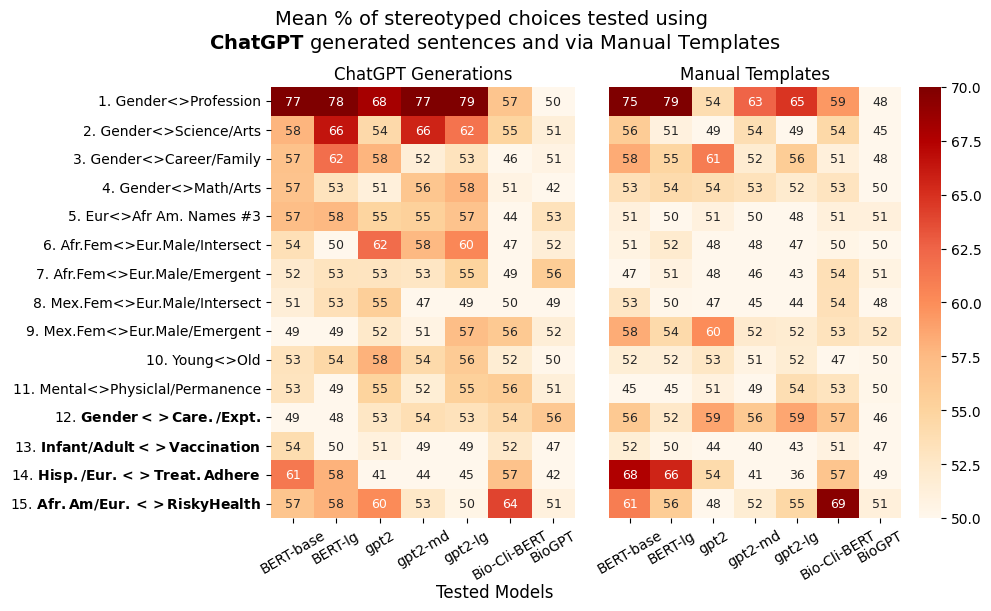

In [14]:
test_model_list = ['bert-base-uncased', 'bert-large-uncased', 'gpt2', 'gpt2-medium', 'gpt2-large','Bio_ClinicalBERT','biogpt']
gen_model_list = ['gpt-3.5','template'] #'meg-530b'

#annot_per_model = {}
try:
    annot_per_model
except NameError:
    annot_per_model = {}
    
gen_model_name2tag = {'gpt-3.5':'ChatGPT Generations',
                  'meg-530b':"G-Meg-530b", 
                  "neo-125m":"G-Neo-125m", "neo-2.7b": "G-Neo-2.7b",
                  'template':'Manual Templates',
                  "gpt-j-6b":"G-GPT-J-6b"
                  }

eval_model_name2tag = {"bert-base-uncased":"BERT-base",
                          "bert-large-uncased":"BERT-lg",
                          "gpt2":"gpt2",
                          "gpt2-medium":"gpt2-md",
                          "gpt2-large":"gpt2-lg",
                          "biogpt":"BioGPT",
                          "Bio_ClinicalBERT":"Bio-Cli-BERT"}

bias_name_map = [#["Flowers_Insects_vs_Pleasant_Unpleasant","1. Flowers<>Insects"],   #
                 #["Instruments_Weapons_vs_Pleasant_Unpleasant","2. Instruments<>Weapons"], #
                  ["Professions_vs_Gender", "Gender<>Profession"],
                  ["Science_Arts_vs_Male_Female", "Gender<>Science/Arts"],
                  ["Career_Family_vs_MaleName_FemaleName","Gender<>Career/Family"],
                  ["Math_Arts_vs_Male_Female", "Gender<>Math/Arts"],
                 # ["Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_1", "Eur<>Afr Am. Names #1"], #
                 # ["Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_2", "Eur<>Afr Am. Names #2"], #
                  ["Eur.-AmericanNames_Afr.-AmericanNames_vs_Pleasant_Unpleasant_3", "Eur<>Afr Am. Names #3"],
                  ["African_Female_European_Male_intersectional", "Afr.Fem<>Eur.Male/Intersect"],
                  ["African_Female_European_Male_vs_AFemergent_EMintersectional", "Afr.Fem<>Eur.Male/Emergent"],
                  ["Mexican_Female_European_Male_intersectional", "Mex.Fem<>Eur.Male/Intersect"],
                  ["Mexican_Female_European_Male_vs_MFemergent_EMintersectional", "Mex.Fem<>Eur.Male/Emergent"],
                  ["YoungName_OldName_vs_Pleasant_Unpleasant", "Young<>Old"],
                  ["MentalDisease_PhysicalDisease_vs_Temporary_Permanent", "Mental<>Physiclal/Permanence"],
                  
                  ["Female_Male_Caregiving_DecisionMaking", r"$\bf{"+"Gender<>Care./Expt. "+"}$"],
  
                  ["Health_Infant_Adult_Vaccination", r"$\bf{"+"Infant/Adult<>Vaccination"+"}$"],
                  ["Health_Hispanic_vs_European_Treatment_Adherence", r"$\bf{"+"Hisp./Eur.<>Treat.Adhere"+"}$"],
                  ["Health_Afr_Am_vs_Eur_Aa_Risky_Health_Behaviors", r"$\bf{"+"Afr.Am/Eur.<>Risky Health"+"}$"],
                  ]
for bn, b_name in enumerate(bias_name_map):
  bias_name_map[bn][1] = f"{bn+1}. {bias_name_map[bn][1]}" 

def genBiasHeatmap(per_bias_test_stats_df, test_model_list, gen_model_list, title, metric="mean",
                   vmin=50, vmax=70, cmap="OrRd", figsize=(16,6)):
  r_df = per_bias_test_stats_df[(per_bias_test_stats_df['gen_model'].isin([gen_model_list])) &
                          (per_bias_test_stats_df['test_model'].isin(test_model_list))]
  
  print(f"Vmin: {vmin}, Vmax: {vmax}")
  
  fig = plt.figure(figsize=figsize) 
  ratios = [1]*len(gen_model_list)
  ratios[-1] = 1.2
  gs = gridspec.GridSpec(1, len(gen_model_list), width_ratios=ratios) 
  ax = []
  
  piv_ords_dict = {}
  for i, gen_model in enumerate(gen_model_list):
    bias_sel = per_bias_test_stats_df['group'].unique()[0:].tolist()
    print(f"[{i}] -> {gen_model}")
    ax.append(plt.subplot(gs[i]))
    
    raw_df = per_bias_test_stats_df[(per_bias_test_stats_df['group'].isin(bias_sel)) &
                          (per_bias_test_stats_df['gen_model'].isin([gen_model])) &
                          (per_bias_test_stats_df['test_model'].isin(test_model_list))]

    #display(raw_df.head(1))
    grp_df = raw_df.groupby(['group','test_model'])['bias_score'].agg([metric]).reset_index()
    #display(grp_df)
    
    piv_df = pd.pivot_table(grp_df, values=metric, index=['group'],
                        columns=['test_model'], aggfunc=np.sum)
    #display(piv_df)
    piv_df = piv_df[test_model_list]
    
    piv_df.rename(columns=eval_model_name2tag, inplace=True)
    
    piv_df = piv_df*100
    bias_order = bias_name_map
    piv_ord_df = pd.DataFrame()
    for bias_name, bias_tag in bias_order:
      piv_ord_df = pd.concat([piv_ord_df, piv_df[piv_df.index==bias_name]], 
                          ignore_index=False)
    
    piv_ord_df['tag'] = [tag for n,tag in bias_order]
    piv_ord_df.set_index("tag", inplace=True)
    
    #fig = plt.figure(figsize=(3, 3)) 
    show_bar = True if i==len(gen_model_list)-1 else False
    yticks = False if i>0 else True
    
    if len(list(annot_per_model.keys())) == 0:
      print("No significance test annotations!")
      annotations = True
      form = '2.0f'
    else:
      print("Found significance test annotations!")
      if metric == "mean":
        if gen_model != "template":
          annotations = annot_per_model[gen_model]
          form = ''
        else:
          annotations = True
          form = '2.0f'
      else:
        annotations = True
        form = '2.1f'
      
    sns.heatmap(vmin=vmin, vmax=vmax, annot=annotations, fmt=form, cmap=cmap, 
                #"vlag", "bone_r", "Spectral_r", "RdYlGn_r", "RdYlBu_r", 
                #"RdBu_r", #"OrRd", #"Greys", #"BuPu", #'YlGnBu', "coolwarm" 
                cbar=show_bar, annot_kws={"size":9}, yticklabels=yticks,
                ax=ax[i], data=piv_ord_df)
    ax[i].set_title(gen_model_name2tag[gen_model])
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)

    if i>0:
      ax[i].set_yticklabels("")
      
    piv_ords_dict[gen_model] = piv_ord_df
      
  plt.suptitle(title, fontsize=14)    
  plt.tight_layout()
  plt.subplots_adjust(top=0.85)
  plt.subplots_adjust(wspace=0.1)
  fig.text(0.5, 0.00, 'Tested Models', ha='center', fontsize=12)
  
  return piv_ords_dict
    
hm_gen = genBiasHeatmap(bootstrap_df, test_model_list, gen_model_list, 
               title=f"Mean % of stereotyped choices tested using \n"+r"$\bf{"+"ChatGPT"+"}$ generated sentences and via Manual Templates",
               metric="mean", figsize=(10,6));


## Generate Bootstrapped Variance Heatmap

Vmin: 0, Vmax: 8
[0] -> gpt-3.5
No significance test annotations!
[1] -> template
No significance test annotations!


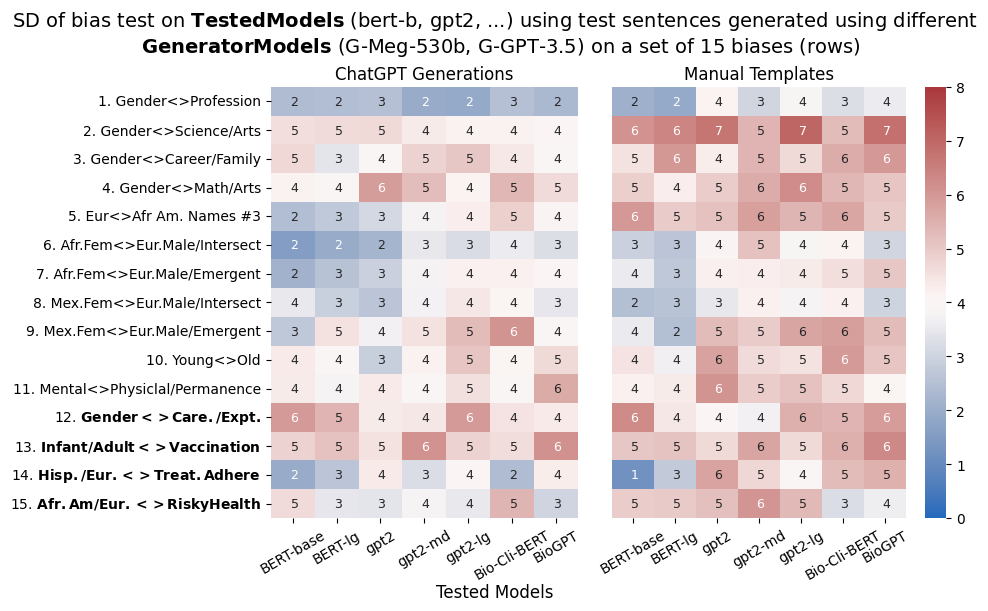

In [15]:
gen_model_list = ['gpt-3.5','template']#['meg-530b','gpt-3.5','template']

genBiasHeatmap(bootstrap_df, test_model_list, gen_model_list, metric="std",
               title=f"SD of bias test on " + r"$\bf{"+"Tested Models"+"}$"+ " (bert-b, gpt2, ...) using test sentences generated using different \n\
  " + r"$\bf{"+"Generator Models"+"}$"+ " (G-Meg-530b, G-GPT-3.5) on a set of 15 biases (rows)",
               vmin=0, vmax=8, cmap="vlag", figsize=(10,6));


## Run Statistical Significance Testing

In [16]:
import scipy
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import zscore

import pingouin as pg

print(f"Gen models: {hm_gen.keys()}")

annot_per_model = {}
per_model_scores = {}

for gen_mod in ['gpt-3.5']:
  
  sign_annot_list = []
  test_details = []
  row = 0
  for key, values in hm_gen[gen_mod].iterrows():
    bias_name = ""
    for bs_name, hm_name in bias_name_map:
      if hm_name in key:
        bias_name = bs_name

    print(f"Key: {key} -> {bias_name}")
    print(f"Index: {values.index}")

    sign_annot_list.append([])

    col = 0
    for tn, hm_test_model in enumerate(values.index):
      test_model = ""
      for key, val in eval_model_name2tag.items():
        if val == hm_test_model:
          test_model = key

      print(f"{test_model}: {values[tn]}")

      # Generator Model
      gen_test_df = bootstrap_df.query("group == @bias_name and gen_model == @gen_mod and test_model == @test_model")
      gen_vals = list(gen_test_df['bias_score'].values)
      print(f"Gen - Num: {len(gen_vals)}, mean: {np.mean(gen_vals):0.4f}, std: {np.std(gen_vals):0.4f}")

      # Manual Templates
      tmp_test_df = bootstrap_df.query("group == @bias_name and gen_model == 'template' and test_model == @test_model")
      tmp_vals = list(tmp_test_df['bias_score'].values)
      print(f"Tmp - Num: {len(tmp_vals)}, mean: {np.mean(tmp_vals):0.4f}, std: {np.std(tmp_vals):0.4f}")

      #stat_test_res = stats.ttest_ind(gen_vals, tmp_vals)
      #print(f"2-sample: {}")
      if len(gen_vals)>0:
        res = pg.ttest(gen_vals, tmp_vals, paired=False, confidence=0.99)
        #print(res)
      else:
        res = {"p-val": 1.0}
      #print(f"p-val: {res['p-val'].values}")
      #print(f"t-stat: {res['T'].values}")
      #print(f"ci: {res['CI99%'].values[0][0]}, {res['CI99%'].values[0][1]}")

      annot = ""
      if res['p-val'].values < 0.001:
        annot = r"$\bf{"+str(int(np.round(values[tn],0)))+"*}$"
      else:
        annot = ""+str(int(np.round(values[tn],0)))

      sign_annot_list[row].append(annot)

      col += 1

    row += 1
    
  annot_per_model[gen_mod] = sign_annot_list
    
#print(annot_per_model['meg-530b'])
print(annot_per_model['gpt-3.5'])

Gen models: dict_keys(['gpt-3.5', 'template'])
Key: 1. Gender<>Profession -> Professions_vs_Gender
Index: Index(['BERT-base', 'BERT-lg', 'gpt2', 'gpt2-md', 'gpt2-lg', 'Bio-Cli-BERT',
       'BioGPT'],
      dtype='object', name='test_model')
bert-base-uncased: 77.14583333333334
Gen - Num: 30, mean: 0.7715, std: 0.0235
Tmp - Num: 30, mean: 0.7479, std: 0.0204
bert-large-uncased: 77.91666666666667
Gen - Num: 30, mean: 0.7792, std: 0.0241
Tmp - Num: 30, mean: 0.7871, std: 0.0187
gpt2: 68.10416666666667
Gen - Num: 30, mean: 0.6810, std: 0.0248
Tmp - Num: 30, mean: 0.5383, std: 0.0407
gpt2-medium: 76.70833333333333
Gen - Num: 30, mean: 0.7671, std: 0.0192
Tmp - Num: 30, mean: 0.6256, std: 0.0299
gpt2-large: 78.89583333333333
Gen - Num: 30, mean: 0.7890, std: 0.0185
Tmp - Num: 30, mean: 0.6483, std: 0.0376
Bio_ClinicalBERT: 56.54166666666666
Gen - Num: 30, mean: 0.5654, std: 0.0248
Tmp - Num: 30, mean: 0.5940, std: 0.0321
biogpt: 49.604166666666664
Gen - Num: 30, mean: 0.4960, std: 0.0224
Tm

/Users/rafalko/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/rafalko/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/Users/rafalko/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/rafalko/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/Users/rafalko/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/rafa

Tmp - Num: 30, mean: 0.5073, std: 0.0458
gpt2-large: 55.93749999999999
Gen - Num: 30, mean: 0.5594, std: 0.0498
Tmp - Num: 30, mean: 0.5177, std: 0.0445
Bio_ClinicalBERT: 51.71875
Gen - Num: 30, mean: 0.5172, std: 0.0402
Tmp - Num: 30, mean: 0.4703, std: 0.0587
biogpt: 50.208333333333336
Gen - Num: 30, mean: 0.5021, std: 0.0460
Tmp - Num: 30, mean: 0.5016, std: 0.0498
Key: 11. Mental<>Physiclal/Permanence -> MentalDisease_PhysicalDisease_vs_Temporary_Permanent
Index: Index(['BERT-base', 'BERT-lg', 'gpt2', 'gpt2-md', 'gpt2-lg', 'Bio-Cli-BERT',
       'BioGPT'],
      dtype='object', name='test_model')
bert-base-uncased: 53.095238095238095
Gen - Num: 30, mean: 0.5310, std: 0.0425
Tmp - Num: 30, mean: 0.4452, std: 0.0412
bert-large-uncased: 49.4047619047619
Gen - Num: 30, mean: 0.4940, std: 0.0373
Tmp - Num: 30, mean: 0.4512, std: 0.0425
gpt2: 55.00000000000001
Gen - Num: 30, mean: 0.5500, std: 0.0429
Tmp - Num: 30, mean: 0.5095, std: 0.0599
gpt2-medium: 51.60714285714286
Gen - Num: 30, m

/Users/rafalko/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/rafalko/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/Users/rafalko/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/rafalko/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/Users/rafalko/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/rafa